בס"ד

ב"ה


**M10 Practical Challenge: Naïve Bayes Sentiment Analysis**

Ben Besthof

DAV6150

03/25/2024

**Introduction**

Naïve Bayes classifiers are widely recognized for their efficacy at classifying text data (e.g., sentiment analysis). As we’ve learned, many organizations rely on sentiment analysis algorithms to help them gauge the opinions of both existing and potential customers. For example, companies such as Amazon, TripAdvisor, Booking.com, WalMart, and Yelp (amongst others) apply sentiment analysis algorithms to the online product/service reviews provided by their customers to better understand how the public perceives competing products and services. There are several ways a model can interpret words, through bag of words, count vectorization, and tfidf vectorization. The objective of this assignment will be to test which method of feature representation leads to the best performing Naive Bayes classifier for movie reviews. Additionally, this assignment will test which of the nltk or sklearn models perform best and which are subjectively easier to implement.

**Bag of words**

A list of key value pairs which the key is any word in the corpus and its corresponding label (positive or negative)


**Count vectorization**

Creates a vector for each unique word in the corpus based on how often that word appears across a document.

**Term Frequency, Inverse Document Frequency (TF-IDF) vectorization**

Creates a vector for each unique word in the corpus based on how often that word appears across the corpus.

Note that the TF-IDF vectorizor and count vectorizor are different in that the TF-IDF vectorizor measures the importance of a word by counting how many times a specific word appears in a document AND across the entire corpus. 




In [1]:
!pip install nltk 
!pip install regex
import pandas as pd
import numpy as np 
import string
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import regex as re 
import sklearn 
from sklearn.naive_bayes import MultinomialNB
import nltk 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("omw-1.4")
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Dealing with unstructured data, specifically text, can get tedious because it takes many forms like reviews or articles. All these forms need to be stored as documents that then need to be compiled into a corpus. In this case each document (review) is stored in a text file and a function is needed to extract the reviews from the text file and land it into a pandas dataframe. Populating a dataset with the reviews will make the corpus of text more readable and easier to analyze. Therefore, a pandas dataframe is created with two variables:

-Sentiment: the class label of the review

-Review: textual content of movie review

The unit of analysis is the sentiment expressed by the movie review text

In [2]:
#creating the dataframe

#defining the paths of the files 
neg_path = '/workspaces/Naive-Reviews/neg/'
pos_path = '/workspaces/Naive-Reviews/pos/'

def get_docs(path, label):

    """ Extractor of text from text files stored in a directory. Populator of existing pandas dataframe wih extracted text data

        Args:
            path (str): path to directory containing text files
            
            label (int): class label of document
        Returns:
            dataframe (pd.DataFrame): dataframe with extracted text and class labels
    """
    #out of this list we will create a dataframe
    data = []
    #open directory
    folder = os.listdir(path)
    for i in folder:
        files = os.path.join(path, i)
        #extract text from each file in directory and append the values to the dataframe
        with open(files, 'r') as file:
            review_text = file.read()
            #add the value pairs review text and sentiment as dictionaries to list so that dictionary can be made into dataframe
            data.append({'sentiment': label,'review': review_text})
    #convert list to dataframe. Pandas can interpret the column row relationship based of key value pairs
    data = pd.DataFrame(data)
    return data

df_neg = get_docs(neg_path, 0)
df_pos = get_docs(pos_path, 1)
#need to union the data together 

#shuffle data so that the model does not interpret a pattern based on position of sentiments (all the negative reviews being listed first and the postive ones last)
df = pd.concat([df_neg, df_pos], axis = 0).sample(frac = 1).reset_index(drop = True)

#creating a copy of the dataset to compare effects of preprocessing
df_copy = df.copy()

df.head()



,sentiment,review
0,1,"after being hypnotized , a man believes there ..."
1,0,plot : something about a bunch of kids going i...
2,0,"the ads for "" batman and robin "" scream "" the ..."
3,1,the seasoned capt . dudley smith ( james cromw...
4,0,everything about this ninth trek movie seems o...


Distribution of positive to negative reviews

In [3]:
df['sentiment'].value_counts()

sentiment
1    1000
0    1000
Name: count, dtype: int64

There are punctiation marks and in the fifth row there is a newline character ('\n') for every time the sentence continues on to the next line of the text file. All of the punctuation marks and newline characters have to be removed from the text so that they are not intepreted as a letter or an individual word during modeling. Stop words like 'to' and 'and' need to be removed because they tend to have higher term frequencies than other words. Additonally all the words will be turned to lower case so that a single word will not be interpreted twice. Looking at the frequency distribution of the terms in positive reviews before data processing will show the effects of keeping punctuation marks and stopwords in the text.

In [4]:
#viewing the distribution of the words in positive reviews before data preprocessing

#extract key value pairs from dataframe
tuples1 = [(df['review'][i], df['sentiment'][i]) for i in range(len(df))]

#separate each review
allwords = df['review'].str.cat(sep = '')

#create list of all the words in the corpus
wordlist = allwords.split()

#gather positive reviews
dfpos = df[df['sentiment'] == 1]


posallwords = dfpos['review'].str.cat(sep = '')
#create list of all the positive words in the corpus
poswordlist = posallwords.split()

#create frequency distribution of positive words
fdist1 = FreqDist(poswordlist)
fdist1.most_common(5)

[(',', 42448), ('the', 41307), ('.', 33714), ('a', 20115), ('and', 19775)]

Cleaning the data will also require for lemmatization or stemming of the text. Lemmatization and stemming are done using nltk and their goal is to reduce the frequency of words with the same meaning. 

**Stemming**

-Reduce the word to its root form. For example, 'bought' and 'buying' are reduced to 'buy'

**Lemmatization**

-Reduces the word to its definitional form. For example, 'am' and 'is' are reduced to 'be'



Lemmatization will be used over stemming because it is easier to understand an alternative maning of a word rather than its three/four letter root. 

**Exploratory Data Analysis**

Preprocessing Data Using Lemmatiztion

In [5]:
def dapptext_lem(dfcolumn):
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download("omw-1.4")

    #create lemmitizer object
    lemmitizer = WordNetLemmatizer()

    #gather new line characters using regex
    pattern = re.compile(r'\n')

    #convert all leters to lower case 
    dfcolumns = dfcolumn.lower()

    #remove new line characters
    clean = pattern.sub('', dfcolumns)

    #gather puntcuation marks using string package
    punks = [i for i in clean if i not in string.punctuation]

    #remove punctuation marks
    cleaner = ''.join(punks)

    #gather stopwords with nltk
    stops = [word for word in cleaner.split(' ') if word not in stopwords.words('english')]

    #remove stopwords
    cleaner = ' '.join(stops)

    #lemmatize words 
    lemons = [lemmitizer.lemmatize(word) for word in cleaner]

    #keep only lemmatuzed words
    cleanest = ''.join(lemons)
    return cleanest
df_copy['review'] = df_copy['review'].apply(dapptext_lem)
df_copy.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[

,sentiment,review
0,1,hypnotized man believes ghost house review t...
1,0,plot something bunch kids going haunted house...
2,0,ads batman robin scream event summer thats...
3,1,seasoned capt dudley smith james cromwell q...
4,0,everything ninth trek movie seems cheap roger...


Most common words in positive and negative lemmatized reviews

In [6]:
#extract key value pairs from dataframe
tuples1 = [(df['review'][i], df['sentiment'][i]) for i in range(len(df))]

tuples_copy = [(df_copy['review'][i], df_copy['sentiment'][i]) for i in range(len(df_copy))]

#gather all text from reviews together
allwords = df_copy['review'].str.cat(sep = '')

#create list of all the words in the corpus
wordlist = allwords.split()

#gather positive reviews
dfpos = df_copy[df_copy['sentiment'] == 1]

#gather negative reviews
dfneg = df_copy[df_copy['sentiment'] == 0]

posallwords = dfpos['review'].str.cat(sep = '')
negallwords = dfneg['review'].str.cat(sep = '')

#create list of all the positive words in the corpus
poswordlist = posallwords.split()

#create list of all the negative words in the corpus
negwordlist = negallwords.split()

#create frequency distribution of positive words
fdist1 = FreqDist(poswordlist)
fdist2 = FreqDist(negwordlist)
print('most common positive words:', fdist1.most_common(5))
print('most common negative words:', fdist2.most_common(5))

most common positive words: [('film', 4866), ('one', 2904), ('movie', 2392), ('like', 1718), ('story', 1215)]
most common negative words: [('film', 3994), ('movie', 3048), ('one', 2617), ('like', 1835), ('even', 1381)]


Might want to consider removing words like film and movie. Like might be a problem because it is a word used for sentiment and comparison. Additionally, film and movie are intepreted as two different words, which shows a weakness in lemmatization. However, a term is currently defined as a single word and it term can be redifned to mean more than one word. Reviews can be analyzed in bigrams (two word terms) and even trigrams (three word terms) to see which results are more interpretable. In other words, the model can interpret if a term is positive based off a pair or a triplet of words.  

In [7]:
#viewing frequency of terms as bigrams and trigrams 

from nltk.tokenize import word_tokenize
from nltk.util import ngrams

#gather positive reviews
dfpos = df_copy[df_copy['sentiment'] == 1]

#gather negative reviews
dfneg = df_copy[df_copy['sentiment'] == 0]

posallwords = dfpos['review'].str.cat(sep = '')
negallwords = dfneg['review'].str.cat(sep = '')

#create list of all the positive words in the corpus
poswordlist = posallwords.split()

#create list of all the negative words in the corpus
negwordlist = negallwords.split()

# Tokenize the text into bigrams
posbigrams = list(ngrams(poswordlist, 2))
negbigrams = list(ngrams(negwordlist, 2))


# Tokenize the text into trigrams
postrigrams = list(ngrams(poswordlist, 3))
negtrigrams = list(ngrams(negwordlist, 3))

#create frequency distribution of positive and negative ngrams
fdist1 = FreqDist(posbigrams)
fdist2 = FreqDist(negbigrams)
fdist3 = FreqDist(postrigrams)
fdist4 = FreqDist(negtrigrams)

print('most common positive bigrams:', fdist1.most_common(15))
print('most common negative bigrams:', fdist2.most_common(15))
print('most common positive trigrams:', fdist3.most_common(15))
print('most common negative trigrams:', fdist4.most_common(15))


most common positive bigrams: [(('special', 'effects'), 171), (('star', 'wars'), 133), (('new', 'york'), 127), (('even', 'though'), 120), (('one', 'best'), 113), (('science', 'fiction'), 84), (('star', 'trek'), 83), (('high', 'school'), 80), (('ive', 'seen'), 77), (('pulp', 'fiction'), 74), (('takes', 'place'), 72), (('ever', 'seen'), 68), (('supporting', 'cast'), 68), (('one', 'day'), 68), (('dont', 'know'), 61)]
most common negative bigrams: [(('special', 'effects'), 203), (('new', 'york'), 117), (('even', 'though'), 102), (('high', 'school'), 92), (('looks', 'like'), 92), (('bad', 'movie'), 71), (('look', 'like'), 70), (('bad', 'guy'), 70), (('im', 'sure'), 65), (('action', 'sequences'), 64), (('running', 'time'), 63), (('dont', 'know'), 62), (('much', 'better'), 61), (('pretty', 'much'), 60), (('action', 'scenes'), 58)]
most common positive trigrams: [(('saving', 'private', 'ryan'), 39), (('ive', 'ever', 'seen'), 31), (('new', 'york', 'city'), 28), (('toy', 'story', '2'), 27), (('r

Bigram and trigram frequency distribution of terms are more interpretable than that of unigrams. Adding a word or two into a term adds context to the term. For example, both positive and negative reviews criticize the special effects used in the movie. Additionally one of the most common phrases in positive bigrams includes the word 'best', which indicates that reviews containing 'best' are generally positive. Common trigrams indicate that viewers generally enjoyed 'Saving Private Ryan' (makes sense because it is considered a top 10 film of all time by many critics), 'Toy Story 2', and movies featuring Robert De Niro in the cast. Negative reviews with trigram represenatation indicate that viewers did not enjoy wild west movies or films featuring Tommy Lee Jones or Freddie Prinze Jr.  Trigram freqdist results are less informative than bigrams because it is less likely that three words co-occur in the same phrase repeatedly throughout the corpus. Therefore, bigram feature representation will be used to train the model. 

In [8]:
#recreating a function that will clean the text even more by removing words like film and movie, and remove non string characters like numbers.

def dapptext(dfcolumn):
        nltk.download('stopwords')
        nltk.download('wordnet')
        nltk.download("omw-1.4")

    #create lemmitizer object
        lemmitizer = WordNetLemmatizer()

    #gather new line characters using regex
        pattern = re.compile(r'\n')
        movies = re.compile(r'movie')
        films = re.compile(r'film')

    #gather 

    #convert all leters to lower case 
        dfcolumns = dfcolumn.lower()

    #remove new line characters
        clean = pattern.sub('', dfcolumns)
    #remove non string characters
        clean = re.sub(r'[^a-zA-Z\s]', '', clean)
        clean = movies.sub('', clean)
        clean = films.sub('', clean)
        

    #gather puntcuation marks using string package
        punks = [i for i in clean if i not in string.punctuation]

    #remove punctuation marks
        cleaner = ''.join(punks)

    #gather stopwords with nltk
        stops = [word for word in cleaner.split(' ') if word not in stopwords.words('english')]

    #remove stopwords
        cleaner = ' '.join(stops)

    #lemmatize words 
        lemons = [lemmitizer.lemmatize(word) for word in cleaner]

    #keep only lemmatuzed words
        cleanest = ''.join(lemons)
        return cleanest
    
df['review'] = df['review'].apply(dapptext)
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[

,sentiment,review
0,1,hypnotized man believes ghost house review t...
1,0,plot something bunch kids going haunted house...
2,0,ads batman robin scream event summer thats...
3,1,seasoned capt dudley smith james cromwell q...
4,0,everything ninth trek seems cheap roger corm...


Checking the distribution of most common terms across the corpus in unigrams and bigrams after cleaning the text again. Unigrams are included in this analysis for comparison purposes despite not selecting them for model training.  

In [9]:
#gather positive reviews
dfpos = df[df['sentiment'] == 1]

#gather negative reviews
dfneg = df[df['sentiment'] == 0]

posallwords = dfpos['review'].str.cat(sep = '')
negallwords = dfneg['review'].str.cat(sep = '')

#create list of all the positive words in the corpus
poswordlist = posallwords.split()

#create list of all the negative words in the corpus
negwordlist = negallwords.split()

# Tokenize the text into bigrams
posbigrams = list(ngrams(poswordlist, 2))
negbigrams = list(ngrams(negwordlist, 2))

#create frequency distribution of positive and negative ngrams

fdist1 = FreqDist(poswordlist)
fdist2 = FreqDist(negwordlist)
fdist3 = FreqDist(posbigrams)
fdist4 = FreqDist(negbigrams)

print('most common positive words:', fdist1.most_common(15))
print('most common negative words:', fdist2.most_common(15))
print('most common positive bigrams:', fdist3.most_common(15))
print('most common negative bigrams:', fdist4.most_common(15))

most common positive words: [('one', 2905), ('like', 1719), ('story', 1216), ('also', 1200), ('good', 1193), ('even', 1174), ('time', 1171), ('characters', 1038), ('much', 1027), ('character', 1013), ('would', 993), ('life', 984), ('well', 968), ('first', 963), ('two', 960)]
most common negative words: [('one', 2617), ('like', 1835), ('even', 1381), ('good', 1128), ('time', 1112), ('would', 1049), ('get', 1037), ('bad', 1019), ('much', 997), ('characters', 909), ('story', 905), ('character', 893), ('plot', 876), ('two', 865), ('make', 819)]
most common positive bigrams: [(('special', 'effects'), 172), (('star', 'wars'), 133), (('new', 'york'), 127), (('even', 'though'), 120), (('one', 'best'), 117), (('science', 'fiction'), 84), (('star', 'trek'), 83), (('high', 'school'), 80), (('ive', 'seen'), 78), (('pulp', 'fiction'), 74), (('takes', 'place'), 72), (('ever', 'seen'), 68), (('supporting', 'cast'), 68), (('one', 'day'), 68), (('dont', 'know'), 61)]
most common negative bigrams: [(('s

The bigram term distribution is more understandable because of the context added by another word. For example the word 'one' appears most frequently across all the reviews. If a predictive model labels 'one' as negative then a review saying'one of the best movies ever' might be classified as negative. The term (one, best) might refer to the phrase "one of the best" especially considering the words "of" and "the" have been removed as stop words by the dapptext preprocessing function. 'One best' yields more information than just 'one'.  Although term frequency is significantly reduced the model might distinguish between positive and negative phrases more accurately with bigrams than unigrams. 

**Feature Extraction**

In [10]:
#extract features from reviews
#extract key value pairs from dataframe
tuples1 = [(df['review'][i], df['sentiment'][i]) for i in range(len(df))]

#creating function to extract terms as bigrams embedding the nltk ngrams function
def extract_features(text):
    bigrams = ngrams(text.split(), 2)
    return dict([(bigram, True) for bigram in bigrams])


featuresets1 = [(extract_features(d), c) for (d,c) in tuples1]


Splitting bag of words features into training and testing sets for NLTK Naive Bayes Classifier

In [11]:
#splitting data into training and testing for NB classifier 
def split_list(inputlist):
    X = np.array(inputlist, dtype = object)
    X75, X25 = train_test_split(X, test_size=0.25, random_state=42)
    subset75 = X75.tolist()
    subset25 = X25.tolist()
    return subset75, subset25

train_set, test_set = split_list(featuresets1)

Splitting features into training and testing sets for sklearn models using. Sklearn split packages turns list of features into an array of words and an array of labels. The manual split function for the nltk model turns features into a list of words and labels.


In [12]:
X = df['review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Naïve Bayes Classifier Training**

**Naive Bayes with NLTK**



The first baseline nltk Naive Bayes model will be trained on a feature set represented as a bag of words.

In [13]:
#training naive bayes model and finding most informative features 
nb_classifier = nltk.NaiveBayesClassifier.train(train_set)
print('\n')
print(nb_classifier.show_most_informative_features(n=30))



Most Informative Features
        ('best', 'year') = True                1 : 0      =     13.1 : 1.0
       ('matt', 'damon') = True                1 : 0      =     13.1 : 1.0
       ('quite', 'well') = True                1 : 0      =     11.1 : 1.0
     ('bad', 'dialogue') = True                0 : 1      =     10.9 : 1.0
       ('fairy', 'tale') = True                1 : 0      =     10.4 : 1.0
  ('best', 'supporting') = True                1 : 0      =      9.0 : 1.0
        ('dark', 'city') = True                1 : 0      =      9.0 : 1.0
     ('kevin', 'spacey') = True                1 : 0      =      9.0 : 1.0
      ('first', 'scene') = True                0 : 1      =      9.0 : 1.0
      ('darth', 'vader') = True                1 : 0      =      8.4 : 1.0
         ('makes', 'us') = True                1 : 0      =      8.4 : 1.0
     ('common', 'sense') = True                0 : 1      =      8.3 : 1.0
       ('worst', 'year') = True                0 : 1      =      8.3 : 1

It seems that the nltk model distinguishes well between positive an negative terms in the training set.

Phrases containing 'best' are correctly interpreted as being positive and terms containing 'worst' are correctly interpreted as being negative. The benefits of using bigram feature representation are apparent. The terms 'common sense' and 'sixth sense' are labeled as positive and negative respectively even though both contain the word 'sense'. Unigram feature representation would classify sense as either positive or negative and could have skewed the model's interpretation of the text. Quite interestingly the model has potential to classify the sentiment of a movie based on who is in it. Movies casting Matt Damon and Kevin Spacey, for example, tend to have more positive reviews according to the nltk model in training. 

**Naive Bayes with Sklearn**

Sklearn provides a package in which one can use a pipeline to train a classifier and the features will be automatically vectorized.

In [14]:
#count vec training 
nb_pipe = Pipeline([('count', CountVectorizer()), ('Naive Bayes', MultinomialNB())])
nb_pipe.fit(X_train, y_train)

#tfidf model training
nb_pipe2 = Pipeline([('tfidf', TfidfVectorizer()), ("Naive Bayes", MultinomialNB())])
nb_pipe2.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('Naive Bayes', MultinomialNB())])

Training an sklearn Naive Bayes model requires less programming both in terms of feature representation and in terms of model training. However, the process of training a model with nltk is more informative. For example, using the most informative features function applied to the training set informs the data scientist which terms the model best interprets during training. 

**Model Testing**

Model testing fits the test data to the trained models and the output labels will be measured. Predictive values will be assessed based on the area under (AUC) the receiver operating characteristic curve (ROC). There will also be a focus on recall to gain a better understanding of the model's predictive value of positive terms. 

**nltk Multinomial Naive Bayes model evaluation**

In [27]:
#ccreating a test set that can be interpreted by sklearn metrics
y_pred_nb = [nb_classifier.classify(feature) for feature, label in test_set]
y_act = [label for feature, label in test_set]

#plotting roc curve
fpr, tpr, thresholds = roc_curve(y_act, y_pred_nb)

print('confusion matrix of nltk model:', '\n', confusion_matrix(y_act, y_pred_nb))
print('classification report of nltk model:', '\n', classification_report(y_act, y_pred_nb))
print('ROC_AUC score of nltk model:', auc(fpr, tpr))

confusion matrix of nltk model: 
 [[185  63]
 [ 45 207]]
classification report of nltk model: 
               precision    recall  f1-score   support

           0       0.80      0.75      0.77       248
           1       0.77      0.82      0.79       252

    accuracy                           0.78       500
   macro avg       0.79      0.78      0.78       500
weighted avg       0.79      0.78      0.78       500

ROC_AUC score of nltk model: 0.7836981566820277


: 

-The nltk multinomial naive bayes classifier has an 82% probability of correctly predicts an event of an actual outcome. 

-A recall of 82% proves the claim made earlier about bigrams leading to best interpretation of terms in positive reviews. 

In [21]:
#classifying a 'new review' with our NB model
nltk.download('punkt')
new_rev = "There were some things I didnt like about this film. Here's what I remember most strongly: a man in an ingeniously fake-looking polar bear costume (funnier than the bear from Hercules in New York); an extra with a less than believable laugh; an ex-drug addict martian with tics; child actors who recite their lines very slowly and carefully; a newspaper headline declaring that Santa has been kidnapped, and a giant robot. The least appealing acting job in the film must be when Mother Claus and her elves have been frozen by the Martians weapons. They seemed to display an exaggerated amount of fear. Perhaps this was the preferred acting style in the 1960s??"
new_tokens = nltk.word_tokenize(new_rev)
new_feats = {word: True for word in new_tokens}
classification = nb_classifier.classify(new_feats)

print(new_rev)
print(classification)


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...


There were some things I didnt like about this film. Here's what I remember most strongly: a man in an ingeniously fake-looking polar bear costume (funnier than the bear from Hercules in New York); an extra with a less than believable laugh; an ex-drug addict martian with tics; child actors who recite their lines very slowly and carefully; a newspaper headline declaring that Santa has been kidnapped, and a giant robot. The least appealing acting job in the film must be when Mother Claus and her elves have been frozen by the Martians weapons. They seemed to display an exaggerated amount of fear. Perhaps this was the preferred acting style in the 1960s??
0


[nltk_data]   Package punkt is already up-to-date!


Although the model correctly classifies this new review it is important to consider that the threshold still needs to be adjusted based of the roc auc curve. By default any review with a class probability below 0.5 will be classified as negative. 

**Sklearn Multinomial Naive Bayes Model evaluation**

Count Vectorizer 

In [22]:
#making predictions on test set
pred = nb_pipe.predict(X_test)

#getting probability assigned to each term
pred_prob = nb_pipe.predict_proba(X_test)[:,1]

#plotting roc curve 
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

#plotting roc auc curve
roc_auc = auc(fpr, tpr)

print('confusion matrix for count vectorizer:', '\n', confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('ROC AUC for Count Vectorizer:', roc_auc)

confusion matrix for count vectorizer: 
 [[207  41]
 [ 50 202]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       248
           1       0.83      0.80      0.82       252

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500

ROC AUC for Count Vectorizer: 0.8801443292370711


Plotting ROC_AUC curve for count vectorizer

(0.0, 1.05)

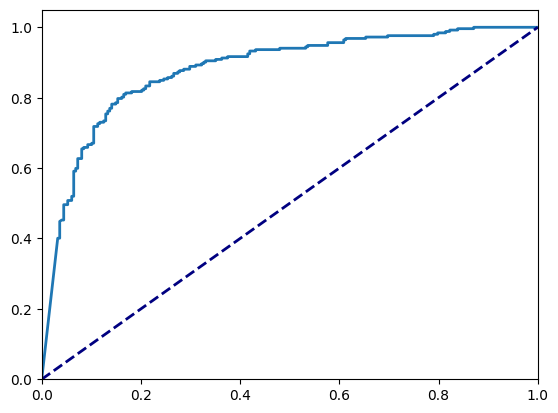

In [23]:
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

The ROC AUC of 88 for the count vectorizer model indicates that the model has a high probability of correctly predicting positive outcomes while minimizing false positives. However, it does not accel in correctly preditcing positive actual outcomes as it does predicting negative outcomes. Although a recall of 80% is considerably good performance for the baseline, correctly predicting actual outcomes is not the model's specialty. 

TFIDF Vectorizer 

In [24]:
pred2 = nb_pipe2.predict(X_test)
pred_proba2 = nb_pipe2.predict_proba(X_test)[:,1]

#plotting roc curve 
fpr, tpr, thresholds = roc_curve(y_test, pred_proba2)

#plotting roc auc curve
roc_auc2 = auc(fpr, tpr)

print('confusion matrix for TFIDF vectorizer:', confusion_matrix(y_test, pred2))
print(classification_report(y_test, pred2))
print('ROC AUC for TFIDF Vectorizer:', roc_auc2)


confusion matrix for TFIDF vectorizer: [[211  37]
 [ 54 198]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       248
           1       0.84      0.79      0.81       252

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500

ROC AUC for TFIDF Vectorizer: 0.89232910906298


(0.0, 1.05)

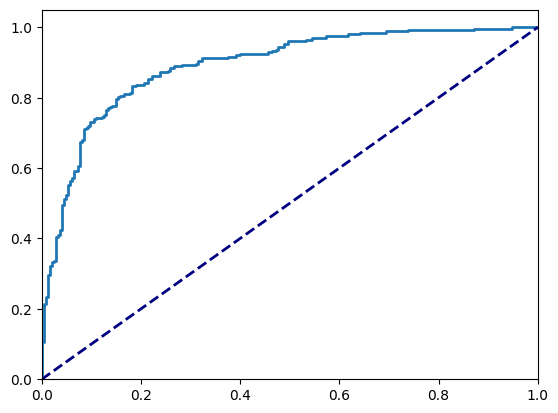

In [25]:
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

The TFIDF vectorizer model plotted the highest ROC AUC of 89. However, it performed the worst in terms compared to the nltk model and the count vectorizer model. One could argue that lower performance might be because the bigram features have relatively lower frequencies and the probability of a two word term repeating across an entire corpus is lower than that of a unigram. In other words, the model did not have sufficient number of terms to effectively distinguish between positive and negative terms. 

**Conclusion**

The best performing model for sentiment analysis of movie reviews is the sklearn multinomial naive bayes classifier using count vectorization. With a high ROC AUC the model has a high probability of correctly predicting actual positive outcomes while minimizing false positives. Nltk's naive bayes classifier accels in correctly prediciting actual positive reviews. Additionally the nltk model can be further optimized by adjusting the threshold. The most informative features of the nltk model showed that the model was correctly interpreting positive and negative terms such as 'best' and 'worst', and it can predict the probability of viewer sentiment based off cast members. 

Generally, the sklearn models were less tedious to train than the nltk model. Furthermore, the sklearn models vary highly across all performance metrics in comparison with the nltk model. This project can be enhanced through testing which form of feature representation is best for high ROC AUC and recall. 